In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
import mlflow
# mlflow ui --backend-store-uri sqlite:///mlflow.db
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775437112812156

/Users/zorikhin/anaconda3/envs/mlzoomcamp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/zorikhin/anaconda3/envs/mlzoomcamp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


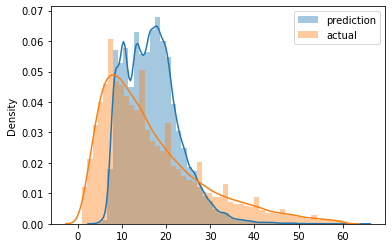

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479340440870557

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "dmitry")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [17]:
import xgboost as xgb

In [18]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[17:59:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:11.22650                                                                                                                          
[1]	validation-rmse:7.92371                                                                                                                           
[2]	validation-rmse:6.97847                                                                                                                           
[3]	validation-rmse:6.69782                                                                                                                           
[4]	validation-rmse:6.58523                                                                                                                           
[5]	validation-rmse:6.54150                                  

KeyboardInterrupt: 

In [24]:
params = {
    'learning_rate': 0.33548318827359175,
    'max_depth': 8,
    'min_child_weight': 3.873376101993617,
    'objective': 'reg:linear',
    'reg_alpha': 0.23963522776886526,
    'reg_lambda': 0.0056820557754435185,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50)

2022/06/01 18:18:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ab34bb52ea244d8dad4a91b85a4e1e1a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[18:18:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.33340
[1]	validation-rmse:11.69326
[2]	validation-rmse:9.51772
[3]	validation-rmse:8.27192
[4]	validation-rmse:7.57586
[5]	validation-rmse:7.18973
[6]	validation-rmse:6.97308
[7]	validation-rmse:6.84587
[8]	validation-rmse:6.77339
[9]	validation-rmse:6.72804
[10]	validation-rmse:6.69925
[11]	validation-rmse:6.67923
[12]	validation-rmse:6.66642
[13]	validation-rmse:6.65373
[14]	validation-rmse:6.64685
[15]	validation-rmse:6.64163
[16]	validation-rmse:6.63790
[17]	validation-rmse:6.63275
[18]	validation-rmse:6.62918
[19]	validation-rmse:6.62647
[20]	validation-rmse:6.62442
[21]	validation-rmse:6.62156
[22]	validation-rmse:6.61839
[23]	validation-rmse:6.61406
[24]	validation-rmse:6.61210
[25]	validation-rmse:6.61010
[26]	validation-rmse:6.60753
[27]	validation-rmse:6.60620
[28]	validat

2022/06/01 18:19:33 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
